EJERCICIO DE CONTROL PID.

A partir del siguiente modelo (Electronics 2020, 9, 1842), desarrollar el controlador PID, ajustando sus parámetros a partir de sus índices de rendimiento.

Modelo:

Modelo motor:

w[0] = w[1] 

i[0] = i[1] 

w[1] = 0.999755 * w[0] + 14.769238 * K * i[0] 

i[1] = 0.574072 * i[0] + 0.383719 * (u(t) - K * w[1]) K=0.0364 

Saturación 24v

Datos del escalón: V0 = 0 km/h Setpoint = 50 km/h Frecuencia de muestreo= 10 Hz Duración del ensayo: 30 s


MODELO DEL MOTOR

In [117]:
class DC_motor_sim:
    def __init__(self):
        self.R = 1.11  # Ohm
        self.L = 0.0002  # H
        self.J = 6.77E-6  # Kgm²
        self.fv = 1.66E-5  # Nm/(Rad/s)
        self.K = 0.0364  # Nm/A or V/(Rad/s)
        self.ea = 0.0
        self.w = [0.0, 0.0]  # tk angular speed
        self.i = [0.0, 0.0]  # tk current

    def init(self):
        self.R = 1.11
        self.L = 0.0002
        self.J = 6.77E-6
        self.fv = 1.66E-5
        self.K = 0.0364
        self.ea = 0.0
        self.w = [0.0, 0.0]
        self.i = [0.0, 0.0]

    def Set_ea(self, new_ea):
        self.ea = new_ea
        # Saturation effect due to battery limits
        if self.ea > 24.0:
            self.ea = 24.0
        if self.ea < -24.0:
            self.ea = -24.


    def Give_me_speed(self): 
        return self.w[0]

    def Exec_cycle(self):
        # Motor behavior considering T = 0.0001s
        self.w[0] = self.w[1]
        self.i[0] = self.i[1]
        self.w[1] = 0.999755 * self.w[0] + 14.769238 * self.K * self.i[0]
        self.i[1] = 0.574072 * self.i[0] + 0.383719 * (self.ea - self.K * self.w[1])

CONTROLADOR PID

In [118]:

class Controller:
    def __init__(self):
        self.Kp = 0.0
        self.Ki = 0.0
        self.Kd = 0.0
        self.Angular_speed_reference = 0.0
        self.Controller_T = 0.001
        self.Noise_Filtering_N = 8
        self.motor_sim = DC_motor_sim()
        self.motor_speed_anterior = 0
        self.I_anterior = 0
        self.D_anterior = 0

    def Init(self, new_Kp, new_Ki, new_Kd):
        self.Kp = new_Kp
        self.Ki = new_Ki
        self.Kd = new_Kd

        self.Angular_speed_reference = 0.0
        self.motor_speed_anterior = 0
        self.I_anterior = 0
        self.D_anterior = 0

        # Inicializar el motor
        self.motor_sim.init()
        

    def Set_reference(self, Angular_speed):
        self.Angular_speed_reference = Angular_speed

    def Exec_controller_cycle(self):
        # Compute control parameters
        motor_speed = DC_motor_sim.Give_me_speed(self.motor_sim)
        error = self.Angular_speed_reference - motor_speed

        P = error * self.Kp
        I = self.I_anterior + self.Kp * self.Controller_T / self.Ki * error if self.Ki !=  0 else 0
        D = self.Kd / (self.Kd + self.Noise_Filtering_N * self.Controller_T) * self.D_anterior - self.Kp * self.Kd * self.Noise_Filtering_N / (self.Kd + self.Noise_Filtering_N * self.Controller_T) * (motor_speed - self.motor_speed_anterior) if self.Kd != 0 else 0
        
        # Prepare last error for next cycle       
        self.motor_speed_anterior = motor_speed

        # Prepare last I and D values for next cycle
        self.I_anterior = I
        self.D_anterior = D
        
        # Compute controller output
        new_motor_voltage = P+I+D
        DC_motor_sim.Set_ea(self.motor_sim, new_motor_voltage)
        DC_motor_sim.Exec_cycle(self.motor_sim)

        return motor_speed, new_motor_voltage

Ejercicio 1: implementar la función def Exec_controller_cycle(self), la cual calcula la señal de control u(t) para la siguiente iteración de control y realiza una llamada al simulador del motor para que actualice sus parámetros.
Una vez implementada esta función, se probará con el siguiente código:

In [119]:
from matplotlib import pyplot as plt

def runControllerTest(Kp = 0.0, Ki = 0.0, Kd = 0.0, vref = 50.0):

    fig, ax = plt.subplots()
    fig, ax2 = plt.subplots()

    
    # Crear una instancia del controlador
    controller = Controller()

    # Inicializar el controlador con los valores de ganancia
    controller.Init(Kp, Ki, Kd)

    # inicializar parámetros
    velocidad=[]
    ut=[]
    coordenadax=[]

    # Asignar el setpoint de 50 km/h
    Velocidad_de_referencia = vref

    # Establecer la velocidad de referencia en el controlador
    controller.Set_reference(Velocidad_de_referencia)

    # Ejecutar 320 ciclos del controlador
    for ite in range(320):
        x,y = controller.Exec_controller_cycle()
        velocidad.append(x)
        ut.append(y)
        coordenadax.append(ite)
        
    # Dibujar el resultado de los 320 ciclos    
    ax.plot(coordenadax, velocidad, linewidth=2.0)
    ax.set_title('Motor Speed (km/h)')
    ax.grid(axis='x', color='0.95')
    ax.grid(axis='y', color='0.95')
    ax2.plot(coordenadax, ut, linewidth=2.0)
    ax2.set_title('Control Signal')
    ax2.grid(axis='x', color='0.95')
    ax2.grid(axis='y', color='0.95')

    return velocidad, ut

Ejercicio 2: Con el controlador desarrollado:

    1.- Ajustar las ganancias para que el comportamiento tenga un overshoot del 10%
    2.- Ajustar las ganancias para que el tiempo de estabilización Ts sea mínimo
    3.- Ajustar las ganancias para que el error en régimen estacionario Ess sea mínimo
    4.- Ajustar las ganancias para que no haya overshoot
    5.- Ajustar las ganancias que minimicen todos los errores

### Ejercicio 2.1
Ajustar las ganancias para que el comportamiento tenga un overshoot del 10%

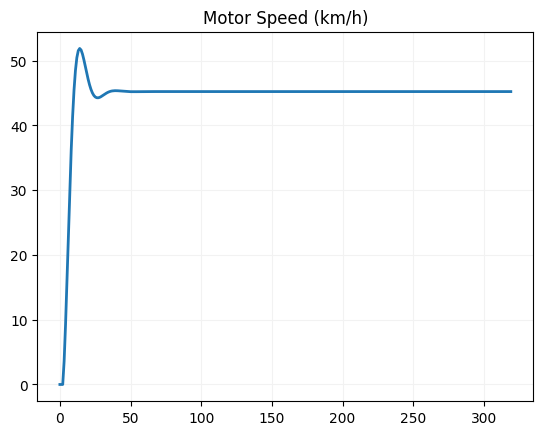

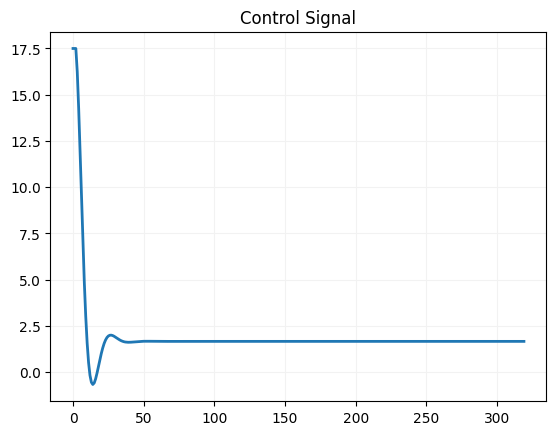

In [120]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.35 # Ajustamos Kp
Ki = 0
Kd = 0
ret = runControllerTest(Kp,Ki,Kd)

### Ejercicio 2.2
Ajustar las ganancias para que el tiempo de estabilización Ts sea mínimo

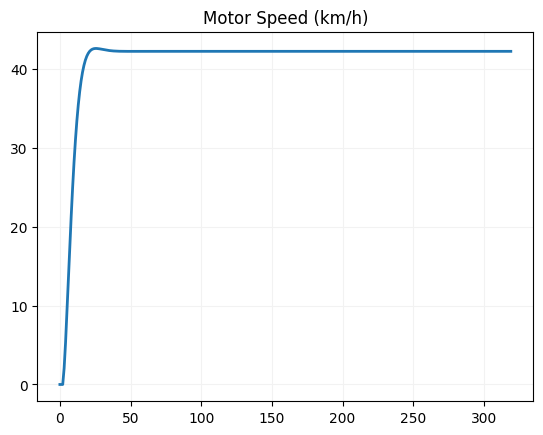

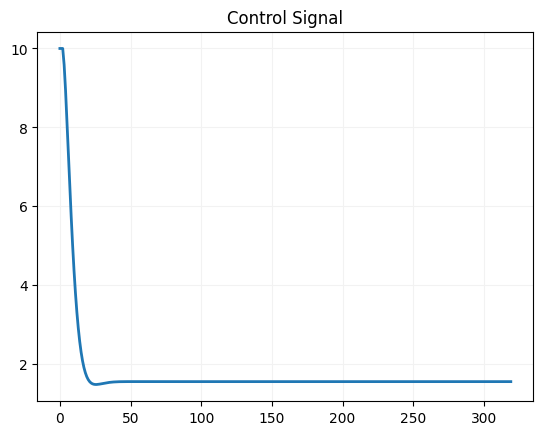

In [121]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.2 # Ajustamos Kp
Ki = 0
Kd = 0
ret = runControllerTest(Kp,Ki,Kd)

### Ejercicio 2.3
Ajustar las ganancias para que el error en régimen estacionario Ess sea mínimo

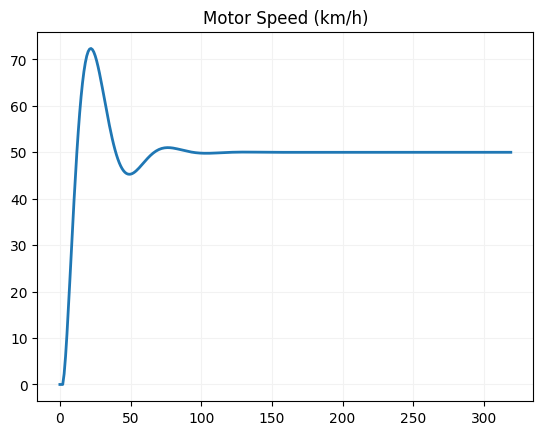

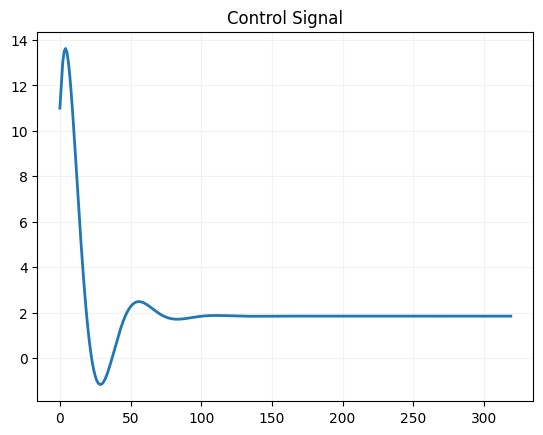

In [122]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.2
Ki = 0.01 # Añadimos Ki para eliminar el Ess)
Kd = 0
ret = runControllerTest(Kp,Ki,Kd)

### Ejercicio 2.4
Ajustar las ganancias para que no haya overshoot

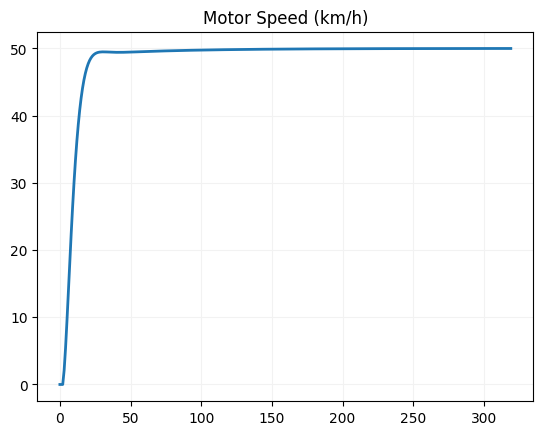

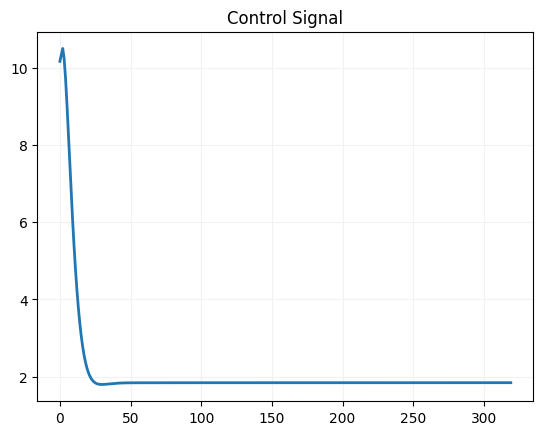

In [123]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.2
Ki = 0.06 # Ajustamos Ki para eliminar el overshoot
Kd = 0
ret = runControllerTest(Kp,Ki,Kd)

### Ejercicio 2.5
Ajustar las ganancias que minimicen todos los errores

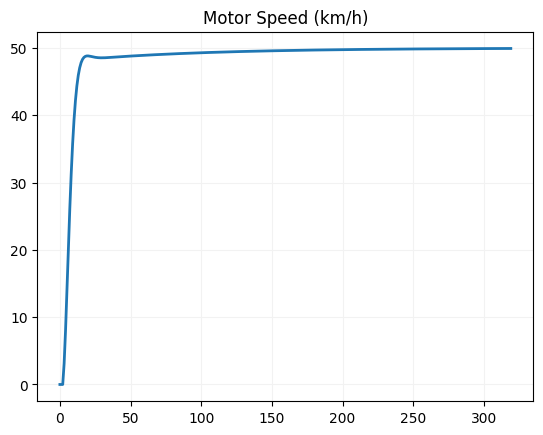

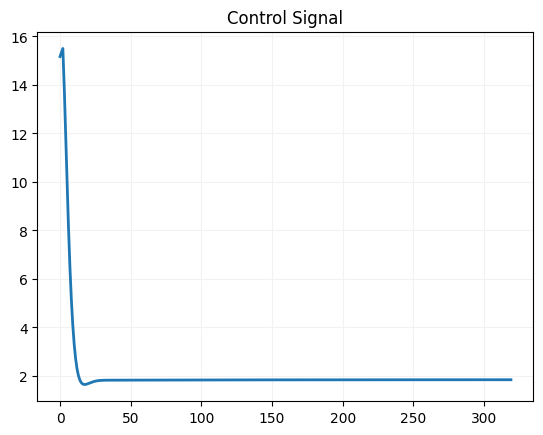

In [226]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.3
Ki = 0.09
Kd = 0.001
ret = runControllerTest(Kp,Ki,Kd)

Ejercicio 3: Comprobación de los índices de rendimiento.
Implementar una función que devuelva los 4 índices de rendimiento más relevantes: Overshoot, Ess, Ts y d.
Una vez implementada esta clase, se obtendrán los índices de rendimiento para las 5 configuraciones de ganancias del Ejercicio 2

In [125]:

import numpy as np
import statistics as stat

SAMPLE_PERIOD_DEFAULT = 0.001

class Performance:    
    def __init__(self):
        self.Overshoot = 0.0
        self.d = 0.0
        self.Ess = 0.0
        self.Ess_percent = 0.0
        self.Ts = 0.0
        self.v = []
        self.VR = 0.0

    def Init(self, velocidades, Velocidad_de_referencia):
        self.Overshoot = 0.0
        self.d = 0.0
        self.Ess = 0.0
        self.Ess_percent = 0.0
        self.Ts = 0.0
        self.v = velocidades
        self.VR = Velocidad_de_referencia
        
    def Calcula_indexes(self):
   
        # Get number of samples
        num_samples = len(self.v)

        # Sample index where signal is considered stable (last 30% of points are considered stable)
        n_stable = round(num_samples * 0.30) 
        settle_value = sum(self.v[-n_stable:]) / n_stable

        # print(f"num_samples: {num_samples}, n_stable: {n_stable}, settle_value: {settle_value}")

        # Calculate Overshoot
        # self.Overshoot = max(self.v) / settle_value - 1

        # Iterate over curve and get all max points
        rising = True if self.v[0] < self.v[1] else False
        max_count = 0 # max point counter
        max_values = [] # list to save all max values
        for i, point in enumerate(self.v):
            if i == 0: continue # skip the first (will always compare each point with the previous one)
            elif rising:
                if point < self.v[i-1]: # not rising anymore
                    rising = False
                    max_count += 1
                    max_values.append({'x': i-1, 'y': self.v[i-1]}) # save local maxima
            else: # If decreasing
                if point > self.v[i-1]: # rising again
                    rising = True

        # print(f"max_count: {max_count}, max_values:")
        # print(max_values)
        
        # Calculate overshoot
        if len(max_values) > 0:
            self.Overshoot = max_values[0]['y'] / settle_value - 1
            if self.Overshoot < 0:
                # A local maxima that isn't over steady state value isn't considered overshoot
                self.Overshoot = 0 

        # Calculate second overshoot
        second_overshoot = 0
        if len(max_values) > 1:
            second_overshoot = max_values[1]['y'] / settle_value - 1

        # Calculate decay ratio
        if abs(self.Overshoot) > 0:
            self.d = abs(second_overshoot / self.Overshoot)

        # Calculate Steady State Error
        self.Ess = settle_value - self.VR
        self.Ess_percent = abs(self.Ess / settle_value) * 100.0

        # Calculate settling time (5% of steady state value)
        settle_point = -1
        for i, point_i in enumerate(self.v): 
            settle_time_found_flag = True # Flag used to know if for loop reached end or was interrupted
            for j, point_j in enumerate(self.v[i:]): 
                if abs( (point_j - settle_value) / settle_value ) > 0.05:
                    settle_time_found_flag = False # Settle point not reached yet
                    break
            if settle_time_found_flag:
                settle_point = i # Settle point was found
                break;

        self.Ts = settle_point

        if(settle_point == -1):
            print("WARNING: System doesn't reach steady state.")
            self.Overshoot = -1
            self.d = -1
            self.Ess = -1
            self.Ess_percent = -1
            self.Ts = -1
            
        return self.Overshoot, self.d, self.Ess, self.Ess_percent, self.Ts


Para probar el ejercicio 3 se ejecutará el siguiente código:

Overshoot:  -1
d:  -1
Ess:  -1
Ts: -1


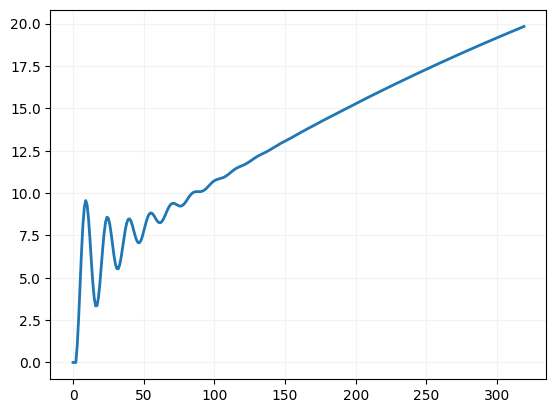

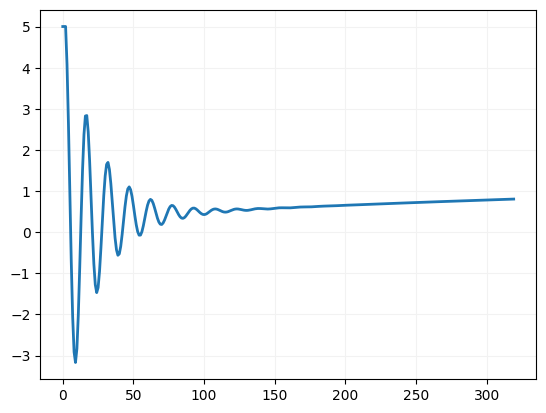

In [126]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
fig, ax2 = plt.subplots()

 
# Crear una instancia del controlador
controller = Controller()

# Asignar valores iniciales a las ganancias del controlador
Kp=0.1
Ki=7
Kd=0.6

# Inicializar el controlador con los valores de ganancia
controller.Init(Kp, Ki, Kd)

# inicializar parámetros
velocidad=[]
ut=[]
coordenadax=[]

# Asignar el setpoint de 50 km/h
Velocidad_de_referencia = 50.0

# Establecer la velocidad de referencia en el controlador
controller.Set_reference(Velocidad_de_referencia)

# Ejecutar 320 ciclos del controlador
for ite in range(320):
    x,y = controller.Exec_controller_cycle()
    velocidad.append(x)
    ut.append(y)
    coordenadax.append(ite)

# Calcular los índices de rendimiento
P = Performance()   
P.Init(velocidad, Velocidad_de_referencia)
o, d, Ess, Ess_percent, Ts = P.Calcula_indexes()
print("Overshoot: ",o)
print("d: ",d)
print("Ess: ",Ess)
print("Ts:", Ts)
    
# Dibujar el resultado de los 320 ciclos    
ax.plot(coordenadax, velocidad, linewidth=2.0)
ax.grid(axis='x', color='0.95')
ax.grid(axis='y', color='0.95')
ax2.plot(coordenadax, ut, linewidth=2.0)
ax2.grid(axis='x', color='0.95')
ax2.grid(axis='y', color='0.95')


In [127]:
def printPerformance(vel_list, vel_ref = 50.0, sample_T = 0.001):
    # Calcular los índices de rendimiento
    P = Performance()   
    P.Init(vel_list, vel_ref)
    o, d, Ess, Ess_percent, Ts = P.Calcula_indexes()
    print(f"Overshoot: {o} ({(o*100.0):.2f} %)")
    print(f"Decay Rate (d): {d} ({(d*100):.2} %)")
    print(f"Ess: {Ess} ({Ess_percent:.2f} %)")
    print(f"Ts: {(Ts * sample_T):.4f} seconds (sample number {Ts})")

### Ejercicio 3.1
(overshoot del 10%)

Overshoot: 0.1005228625493344 (10.05 %)
Decay Rate (d): 0.009971637499686898 (1.0 %)
Ess: -5.350135124590935 (11.98 %)
Ts: 0.0210 seconds (sample number 21)


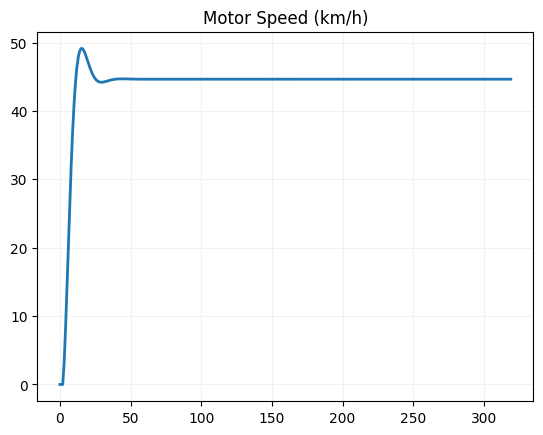

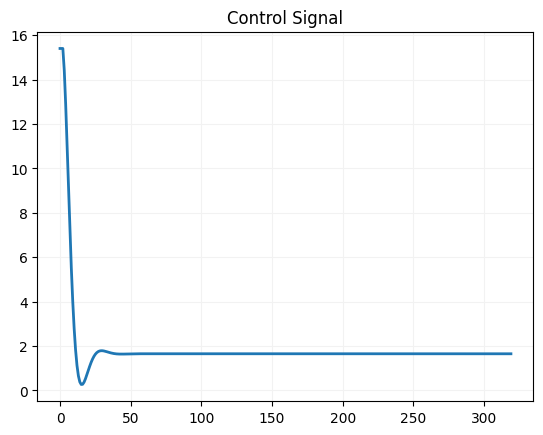

In [138]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.308 # Ajustamos Kp
Ki = 0
Kd = 0

vel, ut = runControllerTest(Kp,Ki,Kd)
printPerformance(vel)

### Ejercicio 3.2
(tiempo de estabilización Ts mínimo)

Overshoot: 0.03526798790555552 (3.53 %)
Decay Rate (d): 0.0012407633310925017 (0.12 %)
Ess: -6.663972216226199 (15.38 %)
Ts: 0.0140 seconds (sample number 14)


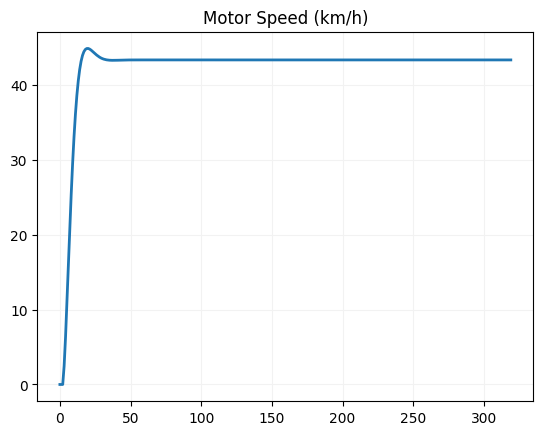

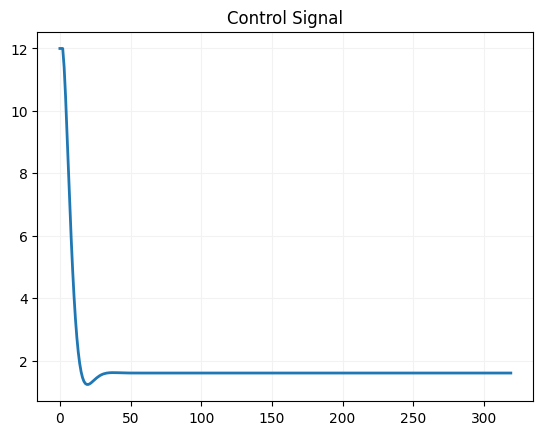

In [151]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.24 # Ajustamos Kp
Ki = 0
Kd = 0

vel, ut = runControllerTest(Kp,Ki,Kd)
printPerformance(vel)

### Ejercicio 3.3
(error en régimen estacionario Ess mínimo)

Overshoot: 0.48101100225446425 (48.10 %)
Decay Rate (d): 0.0416435808737424 (4.2 %)
Ess: -1.3951178701177014e-06 (0.00 %)
Ts: 0.0510 seconds (sample number 51)


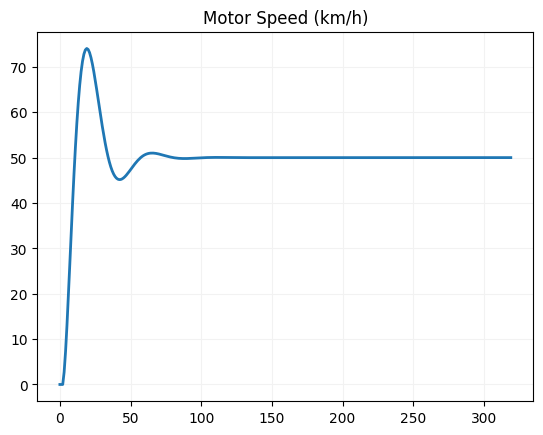

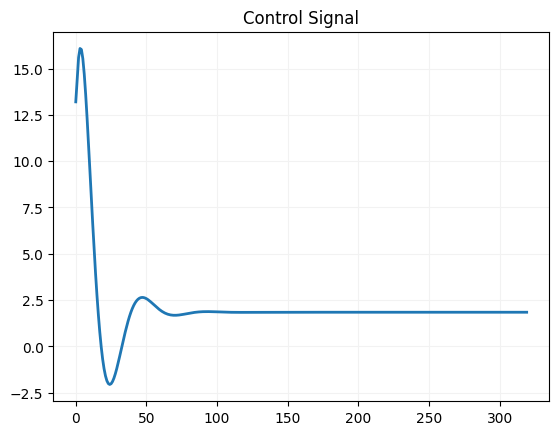

In [152]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.24 
Ki = 0.01 # Añadimos Ki para eliminar el Ess
Kd = 0

vel, ut = runControllerTest(Kp,Ki,Kd)
printPerformance(vel)

### Ejercicio 3.4
(sin overshoot)

Overshoot: 0 (0.00 %)
Decay Rate (d): 0.0 (0.0 %)
Ess: -0.11751474593017974 (0.24 %)
Ts: 0.0160 seconds (sample number 16)


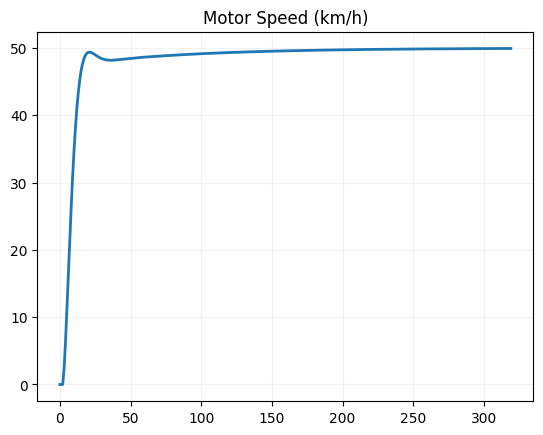

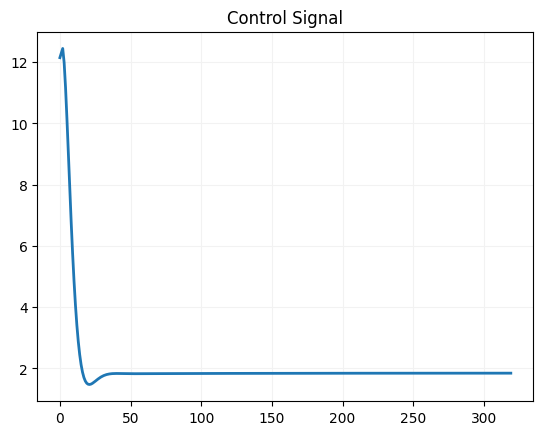

In [157]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.24
Ki = 0.08 # Ajustamos Ki para eliminar el overshoot
Kd = 0

vel, ut = runControllerTest(Kp,Ki,Kd)
printPerformance(vel)

### Ejercicio 3.5
(minimizar todos los errores)

Overshoot: 0 (0.00 %)
Decay Rate (d): 0.0 (0.0 %)
Ess: 0.008914187758257697 (0.02 %)
Ts: 0.0090 seconds (sample number 9)


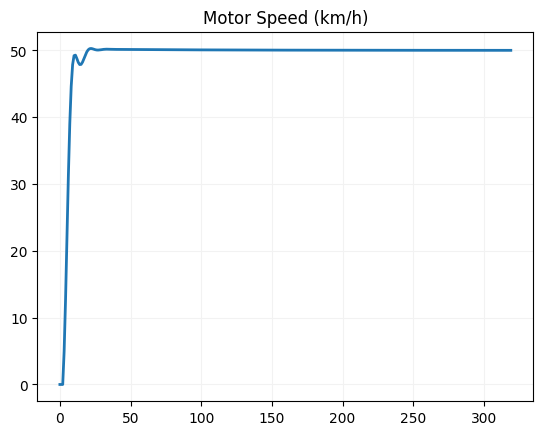

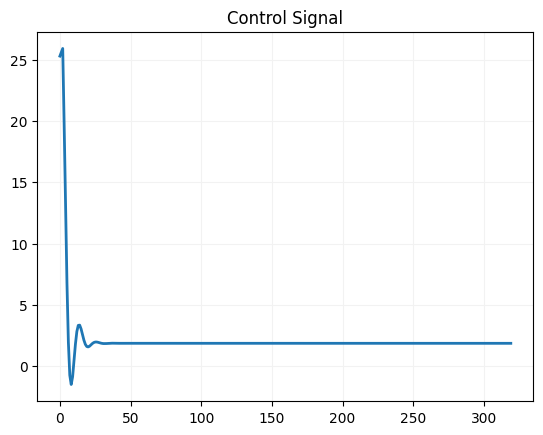

In [204]:
# Asignar valores iniciales a las ganancias del controlador
Kp = 0.5
Ki = 0.08
Kd = 0.002 # Añadimos Kd y ajustamos los otros parámetros también

vel, ut = runControllerTest(Kp,Ki,Kd)
printPerformance(vel)